# 一、手动实现

In [32]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# 1. 高维线性回归

$$
y = 0.05+ \sum^{d}_{i=1}0.01x_{i}+\epsilon
$$
where $\epsilon \sim N(0, 0.01^{2})$

数据集越小，越容易过拟合

In [33]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05

train_data = d2l.synthetic_data(true_w, true_b, n_train)
test_data = d2l.synthetic_data(true_w, true_b, n_test)

test_iter = d2l.load_array(test_data, batch_size, is_train=False)
train_iter = d2l.load_array(train_data, batch_size)

# 1. 初始化模型参数

In [34]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

# 2. 定义$L_{2}$范数惩罚

In [35]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [36]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

# 4. 忽略正则化 直接训练

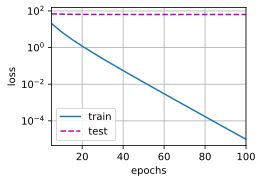

In [37]:
train(lambd=0)

# 5. 使用权重衰退

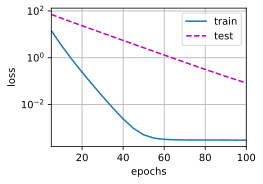

In [38]:
train(lambd=3)

# 二、简洁实现

In [39]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003

    trainer = torch.optim.SGD([
        {'params': net[0].weight, 'weight_decay': wd},
        {'params': net[0].bias}],
        lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss',
                            yscale='log',
                            xlim=[5, num_epochs],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
            if (epoch + 1) % 5 == 0:
                animator.add(epoch + 1,
                             (d2l.evaluate_loss(net, train_iter, loss),
                              d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())




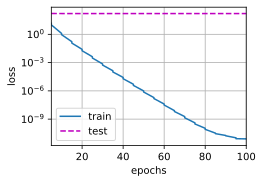

In [40]:
train_concise(0)

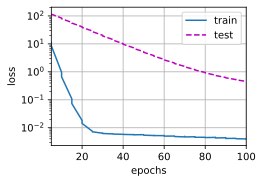

In [41]:
train_concise(3)